# Diffusion Fundamentals

### Diffusion and Score Based Models

In recent years, several methods have arisen for generative modeling of data such as Variational Autoencoders (VAEs), Generative Adversarial Networks (GANs), Autoregressive models, and Normalizing Flows just to name a few. But none really broke the internet quite like the way diffusion models did. Reason being, none could generate images with the same level of quality and diversity as diffusion models. GANs did come close but they were really painful to train and were really unstable. Autoregressive models were too slow. Normalizing Flows were too computationally expensive. VAEs were too blurry. 

The idea was that trying to train a model to generate an image in a single step was too hard, so why not instead let it model it in multiple steps? There were two approaches that were proposed to do this: Score based models and diffusion models. But in both, the idea was that our data could be thought of as a special complicated distribution that we could sample from, and that we could start from a simple distribution such as a normal distribution and find a way to transform samples from this simple distribution into those from the data distribution (or as close as we can get). Therefore, its a problem of going from a random high entropy point in the input space to a low entropy point where the scale of entropy is defined as a continous mapping from the data distribution to the simple normal distribution.

Thus we would start from a random sample from normal distribution aka some random gaussian noise, and iteratively try to find our way to gradually transform it into some sample that looks like it came from the data distribution. We do this in some defined time steps $t$. Thus we define a process of starting from a random noise sample at time $t=0$ and gradually removing the noise and finding some useful data at each time step $t$ until we reach $t=T$ where we have ideally no noise and only data left.

The way score based models tackle this is that they train a model that, given a sample from some time step in the diffusion process, can predict how much noise is still present in it aka predict the time step in a way. Grossly oversimplified, we can basically then find the gradient of the model's output (or score) with respect to the input, and kind of do a gradient descent to remove the noise. 

And the way diffusion models work is by simply training a model that, given an intermediate noised sample, try to denoise the sample a bit at each time step. The time step itself can also be provided to the model to assist it in the process. It has been shown that both score based and diffusion principles are equivalent.

But we need to train the model as well right? How do we do that? Well its pretty intuitive from what we have understood so far: We can simply take samples from our actual data distribution, and construct a set of samples with gradually increasing noise levels by adding gaussian noise at each time step, until we basically have a set of samples that are just noise. This gradual noising process is very similar to the process of diffusion from thermodynamics where particles move from low entropy to high entropy, hence the name. Score based models just stumbled upon the same idea independently.

### The Diffusion Process

The diffusion process (the forward diffusion process) can be described as a stochastic differential equation (SDE):

$dx_t = f(t, x_t) \, dt + g(t, x_t) \, dW_t $

where:
- $dx_t$ is the infinitesimal change in the data sample $x_t$ at time $t$,
- $f(t, x_t)$ is the drift term, which represents the deterministic part of the process,
- $g(t, x_t)$ is the diffusion term, which represents the stochastic part of the process,
- $dW_t$ is the infinitesimal increment of a Wiener process (or standard Brownian motion).

Don't get overwhelmed by the math, its just a fancy way of saying that the data sample at time $t$ is a function of the data sample at time $t-1$ and some noise. The drift term is the deterministic part of the process that tells us how the data sample changes over time, and the diffusion term is the stochastic part that tells us how the noise affects the data sample. We would soon look at how we can model these terms in the form of a defined noise schedule.

Given the above forward-time diffusion process SDE, We can also formulate the reverse-time diffusion process SDE (as found by Anderson (1982)):

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

where:
- $ dx_t $ is the infinitesimal change in the data sample $ x_t $ at time $ t $,
- $ f(t, x_t) $ is the drift term from the forward process,
- $ g(t, x_t) $ is the diffusion term from the forward process,
- $ \nabla_{x_t} \log p_t(x_t) $ is the gradient of the log-density of the data at time $ t $,
- $ d\bar{W}_t $ is the infinitesimal increment of a reverse-time Wiener process (or standard Brownian motion).

Again, its nothing fancy and quite easy to understand when we will later try implementing these.

We will thus implement our forward diffusion process via a Noise schedule and our reverse diffusion process via a Sampler, which is essentially a SDE (or ODE) solver that finds a solution to the above differential equation.

An important thing to note is that Every reverse-time diffusion SDE has a corresponding probability flow ODE with the same marginal densities. This essentially means that we can find solutions to go from a noised sample to a denoised sample in a deterministic manner following an ODE as well. This is the difference between ancestral (like DDPM, Euler-A) and non anscestral samplers (like DDIM, Euler etc). Ancestral samplers solve the SDE, while non-ancestral samplers solve the ODE. The Probability Flow ODE is given by:

$ \frac{dx_t}{dt} = f(t, x_t) - \frac{1}{2} g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t) $

where:
- $\frac{dx_t}{dt}$ is the time derivative of the data sample $x_t$,
- $f(t, x_t)$ is the drift term from the forward process,
- $g(t, x_t)$ is the diffusion term from the forward process,
- $\nabla_{x_t} \log p_t(x_t)$ is the gradient of the log-density of the data at time $t$.

This ODE provides a deterministic trajectory that samples from the same distribution as the original stochastic process.

**We basically use neural networks to estimate the gradient $\nabla_{x_t} \log p_t(x_t)$**

# Imports

In [1]:
import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools
import numpy as np

2024-07-06 23:29:52.032914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Some Important Utils

In [2]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def get_sigmas(self, steps):
        return jnp.tan(self.theta_min + steps * (self.theta_max - self.theta_min)) / self.kappa

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

For simplicity, we will use the oxford flowers dataset for this notebook. We will use the tensorflow datasets library to load the dataset.

In [3]:
def get_dataset(data_name="oxford_flowers102", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.999, 1.05)
            image = tf.image.random_brightness(image, 0.2)

            image = tf.clip_by_value(image, -1.0, 1.0)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        .cache()  # Cache after augmenting to avoid recomputation
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .repeat()  # Repeats the dataset indefinitely
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Schedulers

A Noise schedule governs how noise is added in the forward diffusion steps. Basically, given a time step $t$, it 
returns the signal rate $\alpha$ and noise rate $\sigma_t$ with which to scale the initial data sample $x_0$ and Gaussian noise $\epsilon$ as given by the equation:

$x_t = \alpha_t x_0 + \sigma_t \epsilon_0$

where $x_t$ is the data sample at time $t$, $x_0$ is the initial data sample, and $\epsilon$ is the Gaussian noise, and $\alpha$ and $\sigma_t$ are the signal and noise rates at time $t$ respectively.

In variance preserving diffusion, the noise schedule is such that the variance of the data sample remains constant across time steps. This basically means the following:

$\alpha_t^2 + \sigma_t^2 = 1$

The idea is that with increasing time step $t$, the signal rate $\alpha_t$ decreases and the noise rate $\sigma_t$ increases, decreasing the $%$ of the initial data sample and increasing the amount of noise, slowly diffusing the data sample smoothly to the target normal distribution.

Ofcourse there are many ways to schedule the noise, and the constraint of variance preserving isn't the only way to go about it either. There are Variance exploding and variance preserving schedules as well. In this notebook, we will be looking at the variance preserving noise schedules only.

In [4]:

class NoiseScheduler():
    def __init__(self, timesteps,
                    dtype=jnp.float32,
                    clip_min=-1.0,
                    clip_max=1.0,
                    *args, **kwargs):
        self.max_timesteps = timesteps
        self.dtype = dtype
        self.clip_min = clip_min
        self.clip_max = clip_max
        if type(timesteps) == int and timesteps > 1:
            timestep_generator = lambda rng, batch_size, max_timesteps = timesteps: jax.random.randint(rng, (batch_size,), 0, max_timesteps)
        else:
            timestep_generator = lambda rng, batch_size, max_timesteps = timesteps: jax.random.uniform(rng, (batch_size,), minval=0, maxval=max_timesteps)
        self.timestep_generator = timestep_generator

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        timesteps = self.timestep_generator(rng, batch_size, self.max_timesteps)
        return timesteps, state
    
    def get_weights(self, steps):
        raise NotImplementedError
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray], shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        signal_rates, noise_rates = rates
        signal_rates = jnp.reshape(signal_rates, shape)
        noise_rates = jnp.reshape(noise_rates, shape)
        return signal_rates, noise_rates
    
    def get_rates(self, steps, shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def add_noise(self, images, noise, steps) -> jnp.ndarray:
        signal_rates, noise_rates = self.get_rates(steps)
        return signal_rates * images + noise_rates * noise
    
    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        signal_rates, noise_rates = self.get_rates(steps)
        x_0 = (noisy_images - noise * noise_rates) / signal_rates
        return x_0
    
    def transform_inputs(self, x, steps):
        return x, steps
    
    def get_max_variance(self):
        alpha_n, sigma_n = self.get_rates(self.max_timesteps)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return variance

## Cosine Noise Scheduler

Cosine Schedule is one of the most widely used noise schedules. Its a Variance Preserving noise schedule and can either be parameterized directly as the functions $\alpha(t)$ and $\sigma(t)$ defined directly as 

$\alpha(t) = cos(\dfrac{\pi t}{2 T})$ and $\sigma(t) = sin(\dfrac{\pi t}{2 T})$, 

which is simple to understand as $sin(x)^2 + cos(x)^2 = 1$, which satisfies the variance preserving constraint, 
or in terms of functions depending on a $\beta(t)$ parameter as defined in the original DDPM paper and many more places. 

You see, In the original DDPM Paper, the forward diffusion step is defined as 

$q(x_t|x_{t−1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t−1}, \beta_t I)$

where $q(x_t|x_{t−1})$ is the forward diffusion step. It's the conditional distribution of the data sample $x_t$ given the previous data sample $x_{t-1}$, and the equation states that $x_t$ is normally distributed with mean $\sqrt{1-\beta_t}x_{t−1}$ and variance $\beta_t$.

In human speak, the forward diffusion is phrased as:

$x_t = \sqrt{1-\beta_t}x_{t−1} + \sqrt{\beta_t} \epsilon_t$

where $x_t$ is the data sample at time $t$, $x_{t-1}$ is the previous data sample, and $\epsilon_t$ is the Gaussian noise at time $t$. Notice that $x_t$ is phrased in terms of $x_{t-1}$ instead of the initial data sample $x_0$ as we did in the 'Noise Schedulers' section. 

To convert this formulation to the type we discussed above

$x_t = \alpha_t  x_0 + \sigma_t  \epsilon_0$,

we can find that our signal rate $\alpha_t$ and noise rate $\sigma_t$ can be defined as

$\alpha_t = \prod_t \sqrt{1-\beta_t}$

$\sigma_t = \sqrt{1-\alpha_t^2}$ 

**Note: The thing is, the maths in DDPM paper use the symbol $\alpha$ for a different thing, as an intermediate to denote the value $\alpha_t = 1-\beta_t$, so just be careful with the notation. We use $\alpha$ to denote the signal rate in this notebook.**

We shall thus define the Cosine Noise Scheduler twice: Once in terms of the $\beta(t)$ parameter aka the way its formulated in the DDPM paper, and then in a more simplified way directly in terms of $\alpha(t)$ and $\sigma(t)$.

### Cosine Noise Scheduler in terms of $\beta(t)$

In [24]:
def cosine_beta_schedule(timesteps, start_angle=0.008, end_angle=0.999):
    ts = np.linspace(0, 1, timesteps + 1, dtype=np.float64)
    alphas_bar = np.cos((ts + start_angle) / (1 + start_angle) * np.pi /2) ** 2
    alphas_bar = alphas_bar/alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return np.clip(betas, 0, end_angle)

class CosineDiscreteNoiseSchedule(NoiseScheduler):
    """
    Variance Preserving Noise Scheduler
    signal_rate**2 + noise_rate**2 = 1
    """
    def __init__(self, timesteps,
                    beta_start=0.008, 
                    beta_end=0.999,
                    *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        betas = cosine_beta_schedule(timesteps, beta_start, beta_end)
        self.betas = jnp.array(betas)
        alphas = jnp.cumprod(jnp.sqrt(1 - betas))
        self.alphas = alphas            # This is not the same alpha as mentioned in the original paper!
        self.sigmas = jnp.sqrt(1 - alphas ** 2)
        
    def get_rates(self, steps, shape=()):
        steps = jnp.astype(steps, jnp.int32)
        alpha = self.alphas[steps]
        sigma = self.sigmas[steps]
        alpha = jnp.reshape(alpha, shape)
        sigma = jnp.reshape(sigma, shape)
        return alpha, sigma
    
    def get_weights(self, steps, shape=(-1, 1, 1, 1)):
        return 1 # For simplicity, we are not using weights in this case

### Cosine Noise Scheduler in terms of $\alpha(t)$ and $\sigma(t)$

In [25]:
class ContinuousNoiseScheduler(NoiseScheduler):
    """
    General Continuous Noise Scheduler
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
class CosineContinuousNoiseScheduler(ContinuousNoiseScheduler):
    def get_rates(self, steps, shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        steps = jnp.float32(steps)
        signal_rates = jnp.cos((jnp.pi * steps) / (2 * self.max_timesteps))
        noise_rates = jnp.sin((jnp.pi * steps) / (2 * self.max_timesteps))
        return self.reshape_rates((signal_rates, noise_rates), shape=shape)
    
    def get_weights(self, steps):
        alpha, sigma = self.get_rates(steps, shape=())
        return 1 / (1 + (alpha ** 2 / sigma ** 2))
    

## Lets play with our Noise Schedulers
### Visualization of $\alpha(t)$ and $\sigma(t)$ with linear time steps $t$
to prove that both are equivalent.

Discrete Cosine Noise Schedule


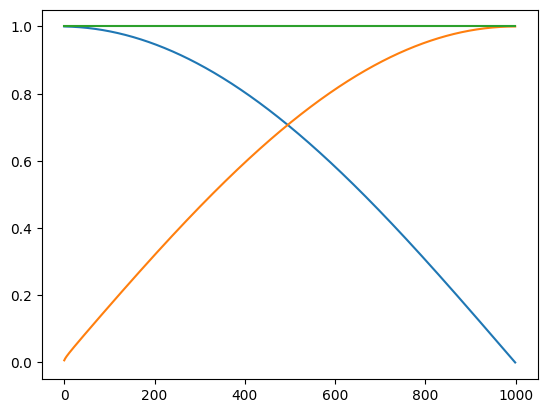

Continuous Cosine Noise Schedule


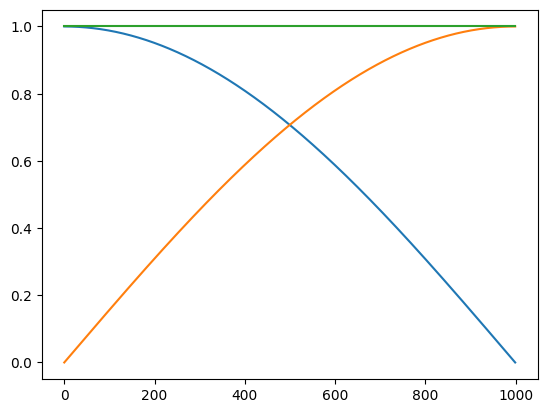

In [26]:
maxT = 1000
timesteps = jnp.linspace(0, maxT, 1000)
get_variance = lambda rates: rates[0] ** 2 + rates[1] ** 2
"""
Lets first plot the signal and noise rates for the discrete cosine noise schedule
"""
print("Discrete Cosine Noise Schedule")
schedule = CosineDiscreteNoiseSchedule(maxT)
plt.plot([schedule.get_rates(i, shape=()) for i in timesteps], label=["signal", "noise"])
plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in timesteps], label="variance")
plt.show()

print("Continuous Cosine Noise Schedule")
schedule = CosineContinuousNoiseScheduler(maxT)
plt.plot([schedule.get_rates(i, shape=()) for i in timesteps], label=["signal", "noise"])
plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in timesteps], label="variance")
plt.show()


### Now lets test the noise scheduler on some simple images

We shall first sample some images from our dataset, then apply some noise to them using the noise scheduler, and then visualize the images at different time steps to see how the noise is added, and then how it is removed.

2024-07-07 00:51:42.862677: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


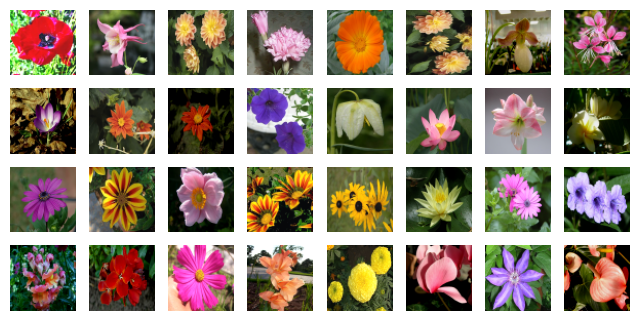

Rates: alpha=[[[[0.7071067]]]], sigma=[[[[0.7071068]]]]
Noisy Images


/tmp/ipykernel_6640/3433040840.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  noise = jax.random.normal(jax.random.PRNGKey(4), shape=images.shape, dtype=jnp.float64)


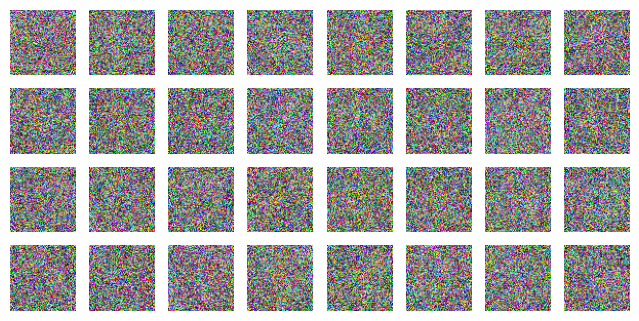

Reconstructed Images


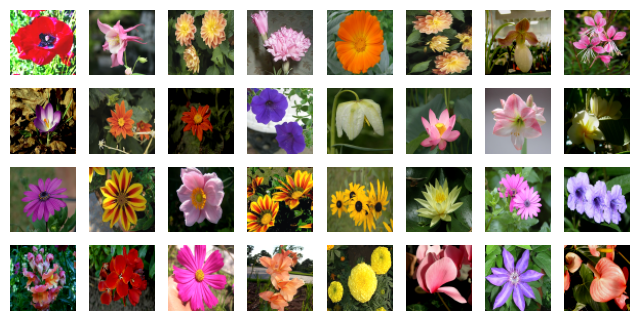

In [28]:
# Visualize adding some noise to some sample images and then removing it
data, _ = get_dataset("oxford_flowers102", batch_size=32, image_scale=64)
images = next(iter(data))
plotImages(images)
noise_level = 500
noise_level_max = 1000
schedule = CosineContinuousNoiseScheduler(noise_level_max)

alpha_t, sigma_t = schedule.get_rates(noise_level)
print(f"Rates: alpha={alpha_t}, sigma={sigma_t}") 
noise = jax.random.normal(jax.random.PRNGKey(4), shape=images.shape, dtype=jnp.float64)
noisy_images = schedule.add_noise(images, noise, noise_level)
print("Noisy Images")
plotImages(noisy_images)
print("Reconstructed Images")
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)

# Modeling

Neural network comes into play for learning to estimate the gradient $\nabla_{x_t} \log p_t(x_t)$ in the reverse diffusion process as described above:

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

Score based models estimate the gradient $\nabla_{x_t} \log p_t(x_t)$ directly as

$ s_{\theta}(x_t) = \nabla_{x_t} \log p_t(x_t) $

where $s_{\theta}(x_t)$ is the score model, and $\theta$ are the parameters of the score model. But we can also model it in terms of a neural network that predicts the actual noise at time $t$ as well

$ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} \approx - s_{\theta}(x_t) = \nabla_{x_t} \log p_t(x_t)  $

where $\epsilon_{\theta}(x_t, t)$ is the denoising model, and $\theta$ are the parameters of the denoising model.
In this notebook, we will be using this denoising model for solving the reverse diffusion process.

## Denoising Model

We will be using a simple UNet architecture for our denoising model. The UNet architecture is a popular architecture for image segmentation tasks, but it proves to be quite useful for denoising tasks as well. The architecture is quite simple and consists of an encoder and a decoder connected by skip connections. The encoder downsamples the input image and extracts features, while the decoder upsamples the features and reconstructs the image. The skip connections help in preserving spatial information and gradients.

We will also add some self attention blocks at each level of the UNet to help the model focus on finding clues in the image that are important for denoising.

The encoder and decoder blocks will be made of several resolution levels, and on each level will be made of several residual blocks, an attention block and a downsampling or upsampling block (for encoder and decoder respectively). There would also be a middle block of a single level of the same design but without downsampling or upsampling.

As our model $\epsilon_{\theta}(x_t, t)$ takes as input the time step $t$ as well, we will feed the model an additional input of the time step $t$ which would be added to each residual block after being embedded in a certain way and transformed and projected by few linear layers. The time step $t$ would be embedded in a way similar to how positional encodings are added in transformers. 

**We shall use the fourier embedding of the time step $t$ in our model.**

**We shall also use separable convolutions in our model to reduce the number of parameters and thus the memory required. If these models do not compile on your machine, try switching all blocks to separable convs and than further reducing the resolution wise feature level sizes.**

## The basic building blocks

In [29]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_in", distribution="truncated_normal")

class NormalAttention(nn.Module):
    """
    Simple implementation of the normal attention.
    """
    query_dim: int
    heads: int = 4
    dim_head: int = 64
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGHEST
    use_bias: bool = True
    kernel_init: Callable = lambda : kernel_init(1.0)

    def setup(self):
        inner_dim = self.dim_head * self.heads
        dense = functools.partial(
            nn.DenseGeneral,
            features=[self.heads, self.dim_head], 
            axis=-1, 
            precision=self.precision, 
            use_bias=self.use_bias, 
            kernel_init=self.kernel_init(), 
            dtype=self.dtype
        )
        self.query = dense(name="to_q")
        self.key = dense(name="to_k")
        self.value = dense(name="to_v")

        self.proj_attn = nn.DenseGeneral(
            self.query_dim, 
            axis=(-2, -1), 
            precision=self.precision, 
            use_bias=self.use_bias, 
            dtype=self.dtype, 
            name="to_out_0",
            kernel_init=self.kernel_init()
            # kernel_init=jax.nn.initializers.xavier_uniform()
        )

    @nn.compact
    def __call__(self, x, context=None):
        # x has shape [B, H, W, C]
        context = x if context is None else context
        query = self.query(x)
        key = self.key(context)
        value = self.value(context)

        hidden_states = nn.dot_product_attention(
            query, key, value, dtype=self.dtype, broadcast_dropout=False, dropout_rng=None, precision=self.precision
        )
        proj = self.proj_attn(hidden_states)
        return proj

class AttentionBlock(nn.Module):
    heads: int = 4
    dim_head: int = 32
    use_linear_attention: bool = True
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGH
    use_projection: bool = False

    @nn.compact
    def __call__(self, x):
        inner_dim = self.heads * self.dim_head
        B, H, W, C = x.shape
        normed_x = nn.RMSNorm(epsilon=1e-5, dtype=self.dtype)(x)
        projected_x = NormalAttention(
            query_dim=C,
            heads=self.heads,
            dim_head=self.dim_head,
            name=f'Attention',
            precision=self.precision,
            use_bias=False,
        )(normed_x)
        out = x + projected_x
        return out
    
class FourierEmbedding(nn.Module):
    features:int
    scale:int = 16

    def setup(self):
        self.freqs = jax.random.normal(jax.random.PRNGKey(42), (self.features // 2, ), dtype=jnp.float32) * self.scale

    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * (2 * jnp.pi * self.freqs)[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb

class TimeProjection(nn.Module):
    features:int
    activation:Callable=jax.nn.gelu

    @nn.compact
    def __call__(self, x):
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        return x

class SeparableConv(nn.Module):
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    use_bias:bool=False
    kernel_init:Callable=kernel_init(1.0)
    padding:str="SAME"

    @nn.compact
    def __call__(self, x):
        in_features = x.shape[-1]
        depthwise = nn.Conv(
            features=in_features, kernel_size=self.kernel_size,
            strides=self.strides, kernel_init=self.kernel_init,
            feature_group_count=in_features, use_bias=self.use_bias,
            padding=self.padding
        )(x)
        pointwise = nn.Conv(
            features=self.features, kernel_size=(1, 1),
            strides=(1, 1), kernel_init=self.kernel_init,
            use_bias=self.use_bias
        )(depthwise)
        return pointwise

class ConvLayer(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    kernel_init:Callable=kernel_init(1.0)

    def setup(self):
        if self.conv_type == "conv":
            self.conv = nn.Conv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "separable":
            self.conv = SeparableConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )

    def __call__(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = x
        # out = PixelShuffle(scale=self.scale)(out)
        B, H, W, C = x.shape
        out = jax.image.resize(x, (B, H * self.scale, W * self.scale, C), method="nearest")
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(1, 1),
        )(out)
        if residual is not None:
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class Downsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(2, 2)
        )(x)
        if residual is not None:
            if residual.shape[1] > out.shape[1]:
                residual = nn.avg_pool(residual, window_shape=(2, 2), strides=(2, 2), padding="SAME")
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class ResidualBlock(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    padding:str="SAME"
    activation:Callable=jax.nn.swish
    direction:str=None
    res:int=2
    norm_groups:int=8
    kernel_init:Callable=kernel_init(1.0)

    @nn.compact
    def __call__(self, x:jax.Array, temb:jax.Array, extra_features:jax.Array=None):
        residual = x
        out = nn.GroupNorm(self.norm_groups)(x)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv1"
        )(out)

        temb = nn.DenseGeneral(features=self.features, name="temb_projection")(temb)
        temb = jnp.expand_dims(jnp.expand_dims(temb, 1), 1)
        out = out + temb

        out = nn.GroupNorm(self.norm_groups)(out)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv2"
        )(out)

        if residual.shape != out.shape:
            residual = ConvLayer(
                self.conv_type,
                features=self.features,
                kernel_size=(1, 1),
                strides=1,
                kernel_init=self.kernel_init,
                name="residual_conv"
            )(residual)
        out = out + residual

        out = jnp.concatenate([out, extra_features], axis=-1) if extra_features is not None else out

        return out

## Main UNet Model

In [30]:

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.mish
    norm_groups:int=8

    @nn.compact
    def __call__(self, x, temb):
        temb = FourierEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs

        conv_type = "conv"
        middle_conv_type = up_conv_type = down_conv_type = "separable"

        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    down_conv_type,
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_in // attention_config['heads'],
                                       name=f"down_{i}_attention_{j}")(x)
                downs.append(x)
            if i != len(feature_depths) - 1:
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)
            if middle_attention is not None and j == self.num_middle_res_blocks - 1:   # Apply attention only on the last block
                x = AttentionBlock(heads=attention_config['heads'], 
                                   dim_head=middle_dim_out // attention_config['heads'],
                                   use_linear_attention=False, name=f"middle_attention_{j}")(x)
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                kernel_size = (3, 3)
                x = ResidualBlock(
                    up_conv_type,
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_out // attention_config['heads'],
                                       name=f"up_{i}_attention_{j}")(x)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)
    
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            conv_type,
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3,3),
            strides=(1, 1),
            activation=self.activation,
            norm_groups=self.norm_groups
        )(x, temb)

        x = nn.GroupNorm(self.norm_groups)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            conv_type,
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

## Validate the model
** The output hasn't been rendered as it is too large to be rendered in the notebook. **

In [ ]:
model = Unet(emb_features=256,
    feature_depths=[64, 128, 256, 512],
    attention_configs=[{"heads":4}, {"heads":4}, {"heads":4}, {"heads":4}],
    num_res_blocks=2,
    num_middle_res_blocks=1)
inp = jnp.ones((1, 64, 64, 3))
temb = jnp.ones((1,))
print(model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

# Training utils